### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_3330.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


###  Separar treino e teste

In [3]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/(len(workload)//60)
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [4]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     27.069021
ar.L1      0.709244
sigma2    21.814906
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [5]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 12, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    model_name = f'/media/danilo/DADOS/SBRC2021/models/arima_{str_test_perc.replace(".","")}_{"".join(map(str, order))}_{machine.replace(".csv", "")}.pkl'
    if not os.path.isfile(model_name):
        # cria e salva um modelo caso não exista
        model_train = ARIMA(train_set, order=order).fit()
        model_test = ARIMA(test_set, order=order, enforce_stationarity=False).fit(model_train.params)
        model_test.save(model_name)
        print(f"Modelo salvo em: '{model_name}' ")
    else:
        # carrega um modelo salvo
        model_test = ARIMAResults.load(model_name)
        
    # guarda os erros de cada modelo em uma lista
    predict_set = model_test.predict().shift(-1)[:-1]
    error = mse(test_set[:-1], predict_set)
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 0, 0) 44.634577269949474 | (0, 0, 1) 17.666963115890365 | (0, 0, 2) 10.641432941784627 | (0, 0, 3) 6.969527045932225 | (0, 0, 4) 5.422111921787695 | (0, 0, 5) 9.683914077752075 | (1, 0, 0) 3.788694564858946 | (1, 0, 1) 3.84193213827876 | (1, 0, 2) 3.8552302148043815 | (1, 0, 3) 3.845012964122452 | (1, 0, 4) 3.874168885313892 | (1, 0, 5) 4.269635793788708 | (2, 0, 0) 3.8481359498189214 | (2, 0, 1) 3.8771063207301997 | (2, 0, 2) 3.948833205592434 | (2, 0, 3) 3.957499756084576 | (2, 0, 4) 3.83597353721869 | (2, 0, 5) 5.058708860744334 | (3, 0, 0) 3.8478444950931623 | (3, 0, 1) 3.9538890780634106 | (3, 0, 2) 4.310069552140117 | (3, 0, 3) 4.166749662820165 | (3, 0, 4) 3.9682567685910284 | (3, 0, 5) 6.854738101737275 | (4, 0, 0) 3.8593469128103095 | (4, 0, 1) 3.9536222211009755 | (4, 0, 2) 3.9338453704458503 | (4, 0, 3) 4.908793197943178 | (4, 0, 4) 3.661303340998229 | (4, 0, 5) 4.6810612522961135 | (5, 0, 0) 3.8871759430250443 | (5, 0, 1) 3.958394692425547 | (5, 0, 2) 3.558426008290581 

### Execução do modelo com os melhores parâmetros

In [6]:
# modelo ARIMA
order=best_order
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

/home/danilo/dev/python/cloud_predict/.cloud_predict/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


const     42.046054
ar.L1     -0.039782
ar.L2      0.522958
ar.L3      0.652198
ar.L4      0.530677
ar.L5     -0.597446
ar.L6     -0.071076
ma.L1      0.765705
ma.L2      0.096331
ma.L3     -0.617454
ma.L4     -0.938427
sigma2    21.296847
dtype: float64

### Comparar previsão x teste

Text(0, 0.5, '% cpu')

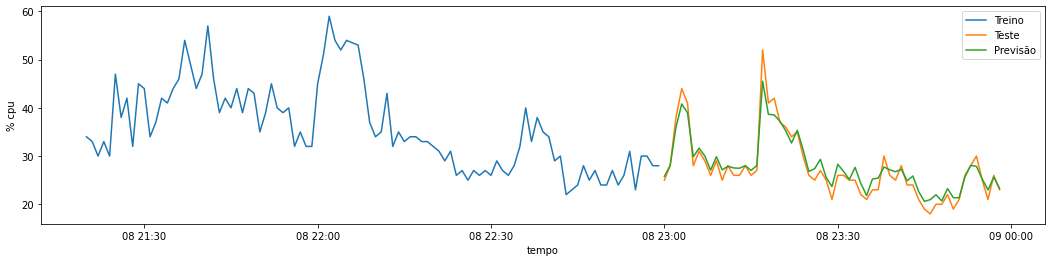

In [11]:
# compara a previsão com o conjunto de teste
predict_set = model_test.predict().shift(-1)[:-1]
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.legend(['Treino', 'Teste', 'Previsão'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Previsão de valores futuros

1970-01-09    22.423484
Freq: T, dtype: float64

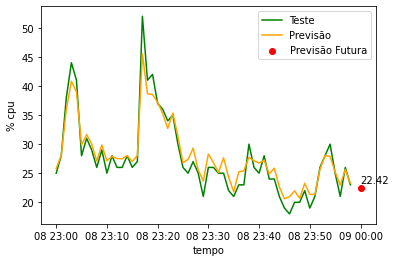

In [23]:
# Próximo passo
predict = model_test.forecast()
plt.figure(figsize=(6,4))
#plt.plot(train_set[-10:])
plt.plot(test_set[:-1], color='green')
plt.plot(predict_set, color='orange')
plt.scatter(predict.index, predict, color='red')
plt.text(predict.index, predict*1.035, f'{predict[0]:.2f}')
plt.legend(['Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')
predict

Text(0, 0.5, '% cpu')

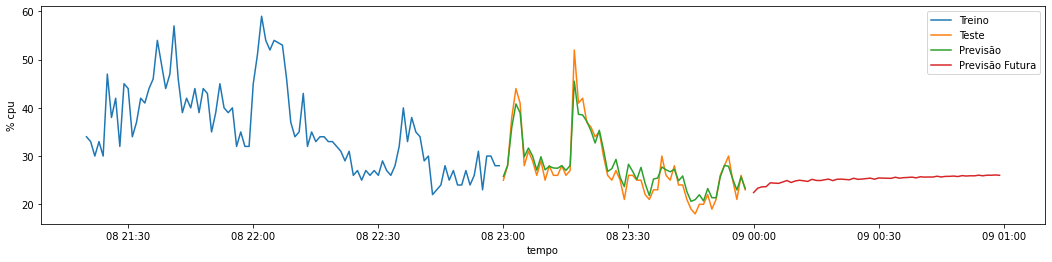

In [9]:
# Conjunto de passos futuros
predict = model_test.forecast(steps=60)
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.plot(predict)
plt.legend(['Treino', 'Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [10]:
mse(test_set[:-1], predict_set)

3.363866070074565